In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#copied from https://www.kaggle.com/code/akashmathur2212/bitcoin-price-prediction-arima-xgboost-lstm-fbprop/notebook#LSTM
file_path = '/content/bitcoin (1).csv'

#   **<span style> 1. Load Bitcoin data </span>**

In [ ]:
dataset = pd.read_csv(file_path)
dataset.head()

,date,price,total_volume,market_cap,coin_name
0,2015-01-01 00:00:00.000,313.992,4.699936e+07,4.293958e+09,bitcoin
1,2015-01-02 00:00:00.000,314.446,3.885591e+07,4.301448e+09,bitcoin
2,2015-01-03 00:00:00.000,286.572,1.187789e+08,3.921358e+09,bitcoin
3,2015-01-04 00:00:00.000,260.936,2.055001e+08,3.571640e+09,bitcoin
4,2015-01-05 00:00:00.000,273.220,1.550381e+08,3.740880e+09,bitcoin


In [ ]:
dataset.describe()

,price,total_volume,market_cap
count,2903.000000,2.903000e+03,2.902000e+03
mean,13303.644712,1.693696e+10,2.462377e+11
std,16368.268775,2.324151e+10,3.096544e+11
min,172.147900,1.823845e+07,2.362640e+09
25%,843.838150,1.002153e+09,1.345601e+10
50%,7309.689244,5.969709e+09,1.295735e+11
75%,17769.365132,2.753158e+10,3.291796e+11
max,67617.015545,4.293082e+11,1.278798e+12


#   **<span style> 1.1 Loading Bitcoin Real world entity data </span>**

In [177]:
ANN_dataset = pd.read_csv('/content/Real world data.csv')
ANN_dataset.head()

,Date,Bitcoin Difficulty Level
0,12/13/2022,3.424433e+13
1,12/12/2022,3.424433e+13
2,12/11/2022,3.424433e+13
3,12/10/2022,3.424433e+13
4,12/09/2022,3.424433e+13


In [178]:
ANN_dataset.describe()

,Bitcoin Difficulty Level
count,1.210000e+02
mean,3.362224e+13
std,3.088933e+12
min,2.817467e+13
25%,3.136055e+13
50%,3.424433e+13
75%,3.676220e+13
max,3.695049e+13


#   **<span>2.Bitcoin Data </span>**

## **<span>2.1 Check any null values present </span>**

In [ ]:
dataset.isnull().sum()

date            0
price           0
total_volume    0
market_cap      1
coin_name       0
dtype: int64

##  **<span>2.2 Plotting Few price data </span>**

In [ ]:
import matplotlib.pyplot as plt
start_date = pd.to_datetime(dataset.date[0])
end_date = pd.to_datetime(dataset.date.values[-1])
dataset['date'] = pd.to_datetime(dataset['date'])

In [ ]:
dataset.tail()

,date,price,total_volume,market_cap,coin_name
2898,2022-12-09,17235.014158,2.267403e+10,3.313899e+11,bitcoin
2899,2022-12-10,17149.824204,2.317983e+10,3.297568e+11,bitcoin
2900,2022-12-11,17125.364928,1.423437e+10,3.292832e+11,bitcoin
2901,2022-12-12,17101.038020,1.568112e+10,3.288688e+11,bitcoin
2902,2022-12-13,17179.596038,2.163383e+10,3.307157e+11,bitcoin


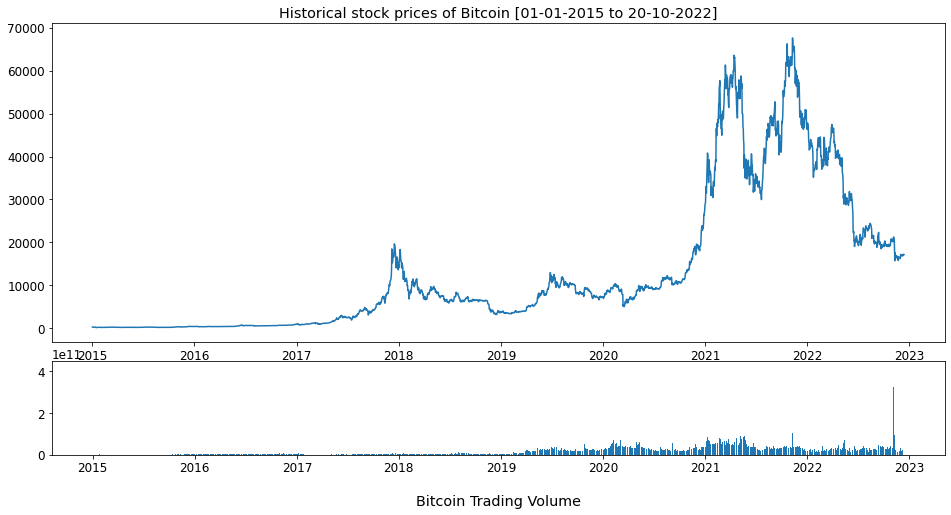

In [ ]:
top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
top_plt.plot(dataset.date, dataset["price"])
plt.title('Historical stock prices of Bitcoin [01-01-2015 to 20-10-2022]')
bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
bottom_plt.bar(dataset.date, dataset['total_volume'])
plt.title('\nBitcoin Trading Volume', y=-0.60)
plt.gcf().set_size_inches(16,10)

In [ ]:
dataset.describe()

,price,total_volume,market_cap
count,2903.000000,2.903000e+03,2.902000e+03
mean,13303.644712,1.693696e+10,2.462377e+11
std,16368.268775,2.324151e+10,3.096544e+11
min,172.147900,1.823845e+07,2.362640e+09
25%,843.838150,1.002153e+09,1.345601e+10
50%,7309.689244,5.969709e+09,1.295735e+11
75%,17769.365132,2.753158e+10,3.291796e+11
max,67617.015545,4.293082e+11,1.278798e+12


## **<span>2.3 Check datatype of Adj Close price </span>**

In [ ]:
dataset['price'].dtype

dtype('float64')

##  **<span>2.4 Find Correlation  </span>**

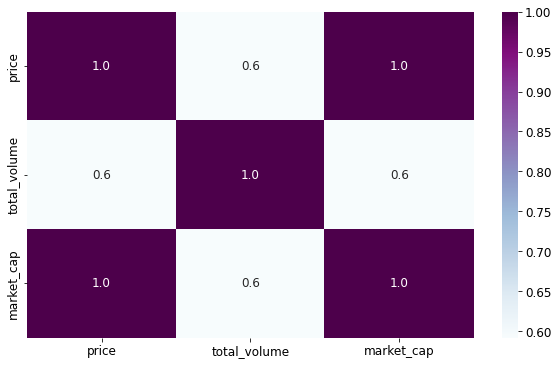

In [ ]:
import seaborn as sns
# plotting correlation heatmap
plt.figure(figsize = (10, 6))
dataplot = sns.heatmap(dataset[['price', 'total_volume', 'market_cap']].corr(), cmap="BuPu", annot=True, 
                      fmt=".1f")
plt.show()

In [ ]:
dataset2 = dataset[['price', 'total_volume']]
dataset2.head()

,price,total_volume
0,313.992,4.699936e+07
1,314.446,3.885591e+07
2,286.572,1.187789e+08
3,260.936,2.055001e+08
4,273.220,1.550381e+08


##  **<span> 2.5 - ADF Test  </span>** 



In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(dataset2.price.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.695924500994944
p-value: 0.43321351047931267
Critial Values:
   1%, -3.432627366129768
Critial Values:
   5%, -2.862546185823105
Critial Values:
   10%, -2.567305621914905


## **<span> 2.6 - Let's apply log transformation to the data and test again </span>** 

In [ ]:
from numpy import log

result = adfuller((log(dataset2.price.values)), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.3944552232828693
p-value: 0.5849314484383357
Critial Values:
   1%, -3.432606151575025
Critial Values:
   5%, -2.8625368163579603
Critial Values:
   10%, -2.567300633673491


In [ ]:
from statsmodels.tsa.stattools import kpss

result = kpss(dataset2['price'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}');


KPSS Statistic: 6.318704
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

#  **<span> 3.Bitcoin price forecasting  </span>**



## **<span> 3.1 Load Data - "price" data  </span>**

In [ ]:
data = dataset2['price'].values
print('Shape of data: ', data.shape)

Shape of data:  (2903,)


## **<span> 3.2 Separate Train and Test data  </span>**

In [ ]:
# Separate train and test data
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', train_data.shape, test_data.shape)

Train length:  2322
Shape of Train and Test data:  (2322,) (581,)


## **<span> 3.3 Change Shape - Need 2D data  </span>**

In [ ]:
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)
print('Shape of Train and Test data: ', train_data.shape, test_data.shape)

Shape of Train and Test data:  (2322, 1) (581, 1)


## **<span> 3.4 Split a Univariate sequence to Supervised Learning  </span>**

In [ ]:
# split a univariate sequence into supervised learning [Input and Output]
def create_dataset(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookback -1):
        a = dataset[i: (i+lookback), 0]
        dataX.append(a)
        b = dataset[i+lookback, 0]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

###  **<span> 3.5 Automatically select Lag value from ACF and PACF graph  </span>**

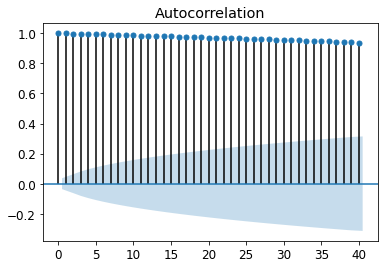

In [ ]:
plot_acf(data, lags=40)
plt.show()

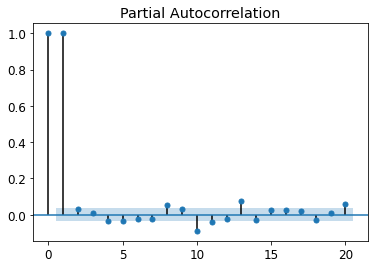

In [ ]:
plot_pacf(data, lags=40)
plt.show()

## **<span> 3.6 Taking Auto-correlation Lag value Greater than 10%  </span>**

In [ ]:
from statsmodels.tsa.stattools import pacf
pacf_value = pacf(data, nlags=20)
lag = 0
# collect lag values greater than 10% correlation 
for x in pacf_value:
    if x > 0.1:
        lag += 1
    else:
        break
print('Selected look_back (or lag = ): ', lag)       

Selected look_back (or lag = ):  2


##  **<span> 3.7 Separate Input and Output  </span>**

In [ ]:
train_X, train_y = create_dataset(train_data, lag)
test_X, test_y = create_dataset(test_data, lag)

In [ ]:
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (2319, 2) (2319,)
Shape of test_X and test_y:  (578, 2) (578,)


*italicized text*##  **<span> 3.8 How Data Looks Like - Input and Output  </span>**

In [ ]:
print(train_data[:20])            # original data
for x in range(len(train_X[:20])):
    print(test_X[x], test_y[x], )            # trainX and trainY after lookback

[[313.992    ]
 [314.446    ]
 [286.572    ]
 [260.936    ]
 [273.22     ]
 [285.3738   ]
 [295.8725   ]
 [284.4525   ]
 [289.5738   ]
 [274.533    ]
 [267.184    ]
 [268.3536677]
 [221.436    ]
 [172.1479   ]
 [210.5559   ]
 [205.816    ]
 [199.4914   ]
 [208.9892   ]
 [214.545    ]
 [210.5137   ]]
[56928.9723566  50004.76218314] 49972.79539837245
[50004.76218314 49972.79539837] 49913.26314398822
[49972.79539837 49913.26314399] 46780.90230468821
[49913.26314399 46780.90230469] 46585.06413538846
[46780.90230469 46585.06413539] 43780.82559782485
[46585.06413539 43780.82559782] 43091.04144756922
[43780.82559782 43091.04144757] 37287.39140242737
[43091.04144757 37287.39140243] 40437.73009625558
[37287.39140243 40437.73009626] 37339.63420134628
[40437.73009626 37339.63420135] 37520.31767547438
[37339.63420135 37520.31767547] 34977.527801962424
[37520.31767547 34977.52780196] 38642.4422973396
[34977.52780196 38642.44229734] 38210.80521759389
[38642.44229734 38210.80521759] 39406.93424411618



##  **<span>4. Build a model  </span>**


##  **<span> 4.1 LSTM model  </span>**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

#copied from https://www.kaggle.com/code/akashmathur2212/bitcoin-price-prediction-arima-xgboost-lstm-fbprop/notebook#Table-of-Contents
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (train_X.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 2, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 2, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 2, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 2, 50)             20200     
                                                                 
 dropout_2 (Dropout)         (None, 2, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)               

In [ ]:
history = regressor.fit(train_X, train_y, validation_split=0.1, epochs = 50, batch_size = 32, verbose=1, shuffle=False)

Epoch 1/50
66/66 [==============================] - 8s 30ms/step - loss: 38554556.0000 - val_loss: 1508050816.0000
Epoch 2/50
66/66 [==============================] - 1s 9ms/step - loss: 38499180.0000 - val_loss: 1507820544.0000
Epoch 3/50
66/66 [==============================] - 1s 9ms/step - loss: 38471340.0000 - val_loss: 1507626752.0000
Epoch 4/50
66/66 [==============================] - 1s 9ms/step - loss: 38447204.0000 - val_loss: 1507443072.0000
Epoch 5/50
66/66 [==============================] - 1s 8ms/step - loss: 38422668.0000 - val_loss: 1507264384.0000
Epoch 6/50
66/66 [==============================] - 1s 8ms/step - loss: 38399064.0000 - val_loss: 1507088896.0000
Epoch 7/50
66/66 [==============================] - 1s 9ms/step - loss: 38375632.0000 - val_loss: 1506915072.0000
Epoch 8/50
66/66 [==============================] - 1s 8ms/step - loss: 38352812.0000 - val_loss: 1506742528.0000
Epoch 9/50
66/66 [==============================] - 1s 8ms/step - loss: 38330404.0000 -

In [ ]:
train_predict = regressor.predict(train_X)
test_predict = regressor.predict(test_X)

19/19 [==============================] - 0s 2ms/step


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
price_series_scaled = scaler.fit_transform(data.reshape(-1,1))
y_train_inv = scaler.inverse_transform(train_y.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(test_y.reshape(-1, 1))
train_predict_inv = scaler.inverse_transform(train_predict)
test_predict_inv = scaler.inverse_transform(test_predict)

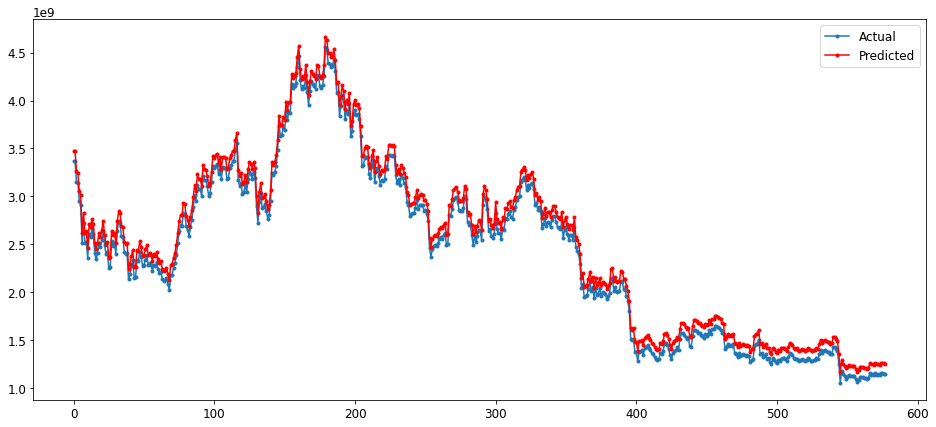

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(test_predict_inv, 'r', marker='.', label="Predicted")
plt.legend()
plt.show()


##  **<span>4.1.1 MAE and RMSE - LSTM model  </span>**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_RMSE = np.sqrt(mean_squared_error(train_y, train_predict))
test_RMSE = np.sqrt(mean_squared_error(test_y, test_predict))
train_MAE = np.sqrt(mean_absolute_error(train_y, train_predict))
test_MAE = np.sqrt(mean_absolute_error(test_y, test_predict))


print(f"Train RMSE: {train_RMSE}")
print(f"Train MAE: {train_MAE}")

print(f"Test RMSE: {test_RMSE}")
print(f"Test MAE: {test_MAE}")

LSTM_RMSE = test_RMSE
LSTM_MAE = test_MAE

Train RMSE: 124.1658
Train MAE: 86.39209116517732
Test RMSE: 256.5186
Test MAE: 189.46906980921136



##  **<span> 4.2 ANN model  </span>**

In [ ]:
# Fix random seed for reproducibility
# Thes seed value helps in initilizing random weights and biases to the neural network.  
np.random.seed(7)

In [ ]:
# ML libraries
from keras.models import Sequential
from keras.layers.core import Dense, Activation
import keras

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim = lag, activation='relu', name= "1st_hidden"))
# model.add(Dense(64, activation='relu', name = '2nd_hidden'))
model.add(Dense(1, name = 'Output_layer', activation='linear'))
# model.add(Activation("linear", name = 'Linear_activation'))
model.compile(loss="mean_squared_error", optimizer="adam")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_hidden (Dense)          (None, 64)                192       
                                                                 
 Output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


# **<span> 4.2.1 Fit data to Model  </span>**

In [ ]:
epoch_number = 100
batches = 64

history = model.fit(train_X, train_y, epochs = epoch_number, batch_size = batches, verbose = 1, shuffle=False, 
                    validation_split=0.1)

Epoch 1/100
33/33 [==============================] - 0s 4ms/step - loss: 22930440.0000 - val_loss: 595329600.0000
Epoch 2/100
33/33 [==============================] - 0s 2ms/step - loss: 7051121.0000 - val_loss: 161933264.0000
Epoch 3/100
33/33 [==============================] - 0s 2ms/step - loss: 1343772.1250 - val_loss: 24342276.0000
Epoch 4/100
33/33 [==============================] - 0s 2ms/step - loss: 179728.3281 - val_loss: 3957466.5000
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 113296.0312 - val_loss: 3074661.5000
Epoch 6/100
33/33 [==============================] - 0s 2ms/step - loss: 113177.6406 - val_loss: 3083896.7500
Epoch 7/100
33/33 [==============================] - 0s 2ms/step - loss: 113020.3828 - val_loss: 3094467.7500
Epoch 8/100
33/33 [==============================] - 0s 2ms/step - loss: 112929.5703 - val_loss: 3091542.0000
Epoch 9/100
33/33 [==============================] - 0s 2ms/step - loss: 112833.9297 - val_loss: 3088984.7500
E

# **<span> 4.3 Train and Validation Loss  </span>**

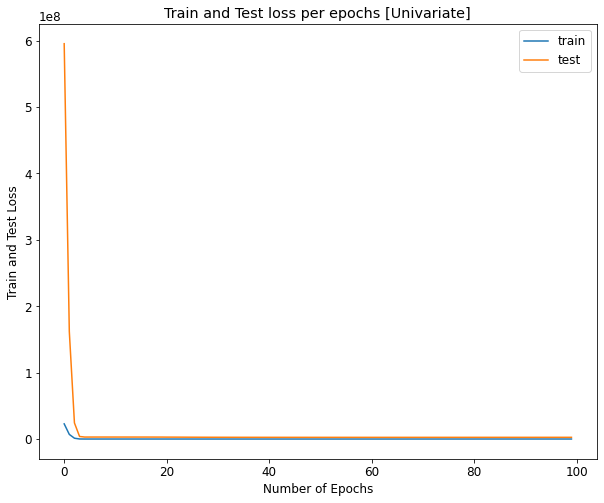

In [ ]:
# plot history
plt.clf
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Number of Epochs')
plt.ylabel('Train and Test Loss')
plt.title('Train and Test loss per epochs [Univariate]')
plt.legend()
plt.show()

## **<span> 4.4 Make Prediction  </span>**

In [ ]:
# Make prediction
testPredict = model.predict(test_X)
predicted_value = testPredict[:, 0]

19/19 [==============================] - 0s 1ms/step


## **<span> 4.5 Evaluation Metrics to Measure Performance  </span>**

* **<span> Mean Absolute Error </span>**

* **<span> Root Mean Squared Error</span>**


In [ ]:
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
ANN_MAE = 0
ANN_RMSE = 0
def evaluate_forecast_results(actual, predicted):
    global ANN_MAE
    ANN_MAE = round(mae(actual, predicted), 2)
    global ANN_RMSE
    ANN_RMSE = round(math.sqrt(mean_squared_error(actual,predicted)), 2)
    print('MAE : ', round(mae(actual, predicted), 2))
    print('RMSE: ', round(math.sqrt(mean_squared_error(actual,predicted)), 2))
    
    

In [ ]:
evaluate_forecast_results(test_y, predicted_value)

MAE :  959.81
RMSE:  1397.1


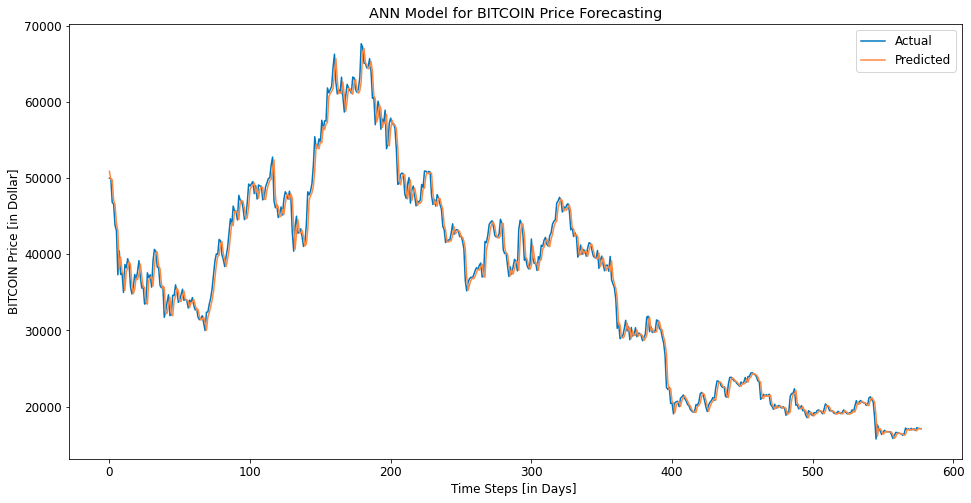

In [ ]:
# Here we're plotting Test and Predicted data

plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 12})
plt.plot(test_y[:], '#0077be',label = 'Actual')
plt.plot(predicted_value, '#ff8841',label = 'Predicted')
plt.title('ANN Model for BITCOIN Price Forecasting')
plt.ylabel('BITCOIN Price [in Dollar]')
plt.xlabel('Time Steps [in Days] ')
plt.legend()
plt.show()


##  **<span> 5 Comparison of Metrics for recommendation  </span>**

In [ ]:
if LSTM_RMSE < ANN_RMSE and LSTM_MAE < ANN_MAE:
  print("Progress with the Recommended value of Bitcoin using LSTM")
else:
  print('Progress with the Recommended value of Bitcoin using ANN')

Progress with the Recommended value of Bitcoin using LSTM


Citation :
1. https://www.kaggle.com/code/debashis74017/time-series-forecasting-itcoin-price/notebook#%F0%9F%93%99--5.-Artificial-Neural-Network---Bitcoin-price-forecasting--

2.https://www.kaggle.com/code/akashmathur2212/bitcoin-price-prediction-arima-xgboost-lstm-fbprop/notebook#LSTM